In [1]:
import json
import bz2
import pymorphy2
from tqdm.notebook import tqdm_notebook as tqdm
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%matplotlib inline

In [2]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

0it [00:00, ?it/s]

## Часть 1. Анализ текстов

In [3]:
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


### 1. Посчитайте количество отзывов в разных городах и на разные банки

In [17]:
df.groupby('city')['num_comments'].sum().sort_values(ascending=False)

city
г. Москва                              210028
г. Санкт-Петербург                      54451
г. Новосибирск                           8206
г. Екатеринбург                          7842
г. Нижний Новгород                       6459
                                        ...  
г. РТ,г.Набережные Челны                    0
г. РТ Бавлы                                 0
г. РП.Пречистое Ярославской области         0
г. РОСТОВ-НА -ДОНУ                          0
г. … или другой населенный пункт            0
Name: num_comments, Length: 5823, dtype: int64

In [18]:
df.groupby('bank_name')['num_comments'].sum().sort_values(ascending=False)

bank_name
Сбербанк России             107056
Тинькофф Банк                55425
Русский Стандарт             43824
Альфа-Банк                   37493
Авангард                     31554
                             ...  
Татсоцбанк                       0
Белгородпромстройбанк            0
Еврокредит                       0
Баренцбанк                       0
Тульский Расчетный Центр         0
Name: num_comments, Length: 670, dtype: int64

### 2. Постройте гистограмы длин слов в символах и в словах

In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\a.pavlovskyi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [4]:
df['tokenized_text'] = df['text'].str.lower().str.replace("[^А-Яа-яё]+", ' ', regex=True).str.strip().apply(word_tokenize)

#### В словах

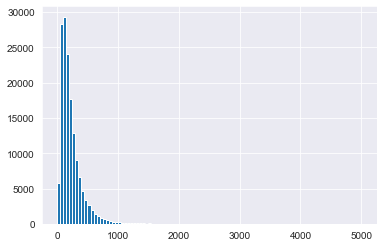

In [17]:
word_lengths = [len(row) for row in df['tokenized_text']]
plt.hist(word_lengths, bins=100)
plt.show()

#### В символах

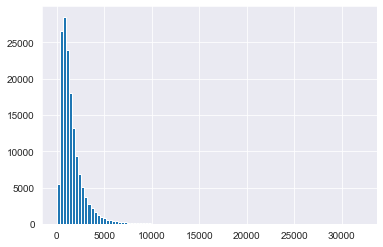

In [18]:
symbols_lengths = [len(row) for row in df['text']]
plt.hist(symbols_lengths, bins=100)
plt.show()

### 3. Найдите 10 самых частых:

#### слов

In [6]:
allWordDist = nltk.FreqDist(list(itertools.chain(*df['tokenized_text'].tolist())))
allWordDist.most_common(10)

[('в', 1330307),
 ('и', 1058997),
 ('не', 852432),
 ('на', 707803),
 ('что', 640057),
 ('я', 577500),
 ('с', 463027),
 ('по', 372759),
 ('мне', 320958),
 ('банка', 275906)]

#### слов без стоп-слов

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a.pavlovskyi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
stopwords = nltk.corpus.stopwords.words('russian')
df['tokenized_text_no_stop_words'] = [[word for word in w if word not in stopwords] for w in df['tokenized_text']]

In [58]:
allWordExceptStopDist = nltk.FreqDist(list(itertools.chain(*df['tokenized_text_no_stop_words'].tolist())))
allWordExceptStopDist.most_common(10)

[('банка', 275906),
 ('банк', 215425),
 ('это', 183365),
 ('деньги', 131201),
 ('карту', 105829),
 ('карты', 101821),
 ('кредит', 81135),
 ('день', 76552),
 ('т', 75759),
 ('банке', 72169)]

#### лемм

In [12]:
m = pymorphy2.MorphAnalyzer()

In [13]:
df['lemmatized_text'] = [' '.join(list((m.parse(word)[0].normal_form for word in w))) for w in tqdm(df['tokenized_text_no_stop_words'])]

  0%|          | 0/153499 [00:00<?, ?it/s]

In [15]:
df.to_feather('df_temp.ftr')

In [2]:
df = pd.read_feather('df_temp.ftr')

In [16]:
lemms = nltk.FreqDist(list(itertools.chain(*df['lemmatized_text'].str.split(' ').tolist())))
lemms.most_common(10)

[('банк', 668547),
 ('карта', 334999),
 ('это', 200057),
 ('деньга', 179819),
 ('день', 173688),
 ('мой', 168999),
 ('кредит', 156176),
 ('который', 149017),
 ('отделение', 144050),
 ('счёт', 142646)]

#### существительных

In [38]:
nouns = []
for w in lemms.most_common():
    if 'NOUN' in m.parse(w[0])[0].tag:
        nouns.append([w[0], w[1]])
nouns[:11]

[['банк', 668547],
 ['карта', 334999],
 ['деньга', 179819],
 ['день', 173688],
 ['кредит', 156176],
 ['отделение', 144050],
 ['счёт', 142646],
 ['клиент', 136892],
 ['сотрудник', 134168],
 ['сумма', 111232],
 ['заявление', 104419]]

### 4. Постройте кривые Ципфа и Хипса

#### Кривая Ципфа

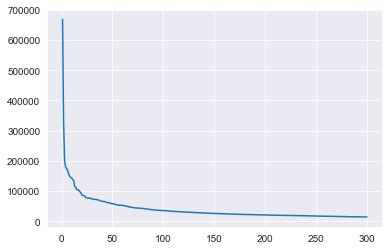

In [18]:
temp_rank = []
temp_data = pd.DataFrame(lemms.most_common(300), columns=['lemm', 'frequency'])
for i, w in enumerate(temp_data['frequency'], 1):
    temp_rank.append(i)

temp_data['rank'] = temp_rank
# temp_data['rank x frequency'] = temp_data['rank'] * temp_data['frequency']
temp_data.sort_values('rank', ascending=True)
plt.plot(temp_data['rank'],temp_data['frequency'])

#### Кривая Хипса

In [39]:
words_list = [m.parse(w)[0].normal_form for w in lemms]

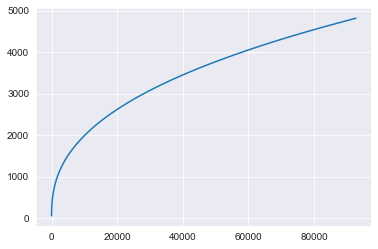

In [42]:
k = 50
b = 0.4

word = set()
r = []

for w in words_list:
    word.add(w)
    r.append(k*len(word)**b)

point = [n for n in range(len(r))]

plt.plot(point, r)

### 5. Ответьте на следующие вопросы:

#### какое слово встречается чаще, "сотрудник" или "клиент"?

In [43]:
if lemms['сотрудник'] > lemms['клиент']:
    print('сотрудник', lemms['сотрудник'])
else:
    print('клиент', lemms['клиент'])

клиент 136892


#### сколько раз встречается слова "мошенничество" и "доверие"?

In [44]:
if lemms['мошенничество'] > lemms['доверие']:
    print('мошенничество', lemms['мошенничество'])
else:
    print('доверие', lemms['доверие'])

мошенничество 3244


### 6. Найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [3]:
df['rating_grade'].value_counts()

1.0    47387
5.0    14713
2.0    13509
3.0     9261
4.0     3788
Name: rating_grade, dtype: int64

#### Сбалансируем выборки

In [3]:
num=10000

# df_sample = df[(df.rating_grade==1)].sample(n=num).copy()
df_sample = pd.concat([df[(df.rating_grade==1)].sample(n=num), df[(df.rating_grade==5)].sample(n=num)])

df_sample.rating_grade.value_counts()

1.0    10000
5.0    10000
Name: rating_grade, dtype: int64

In [58]:
tokens_by_topic = []

for rating in df_sample.rating_grade.unique():
    tokens=[]
    sample=df_sample[df_sample['rating_grade']==rating]

    for i in range(len(sample)):
        tokens += sample['lemmatized_text'].iloc[i].split()

    tokens_by_topic.append(tokens)

#### Униграммы

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names_out()
tfidf_ranking_5 = []
tfidf_ranking_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_5.append(phrase)

text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_1.append(phrase)

In [60]:
rank = pd.DataFrame({'tfidf_ranking_5': tfidf_ranking_5,'tfidf_ranking_1': tfidf_ranking_1})
rank.head(10)

,tfidf_ranking_5,tfidf_ranking_1
0,банк,банк
1,карта,карта
2,это,это
3,очень,деньга
4,день,день
5,кредит,мой
6,клиент,отделение
7,отделение,который
8,который,счёт
9,мой,кредит


#### Убираем пересечения

In [61]:
rank['tfidf_ranking_5_without_1']=rank.tfidf_ranking_5[~rank.tfidf_ranking_5.isin(rank.tfidf_ranking_1)]
rank['tfidf_ranking_1_without_5']=rank.tfidf_ranking_1[~rank.tfidf_ranking_1.isin(rank.tfidf_ranking_5)]

In [62]:
rank.iloc[:,-2:].dropna()

,tfidf_ranking_5_without_1,tfidf_ranking_1_without_5
20,обслуживание,ответ
44,пользоваться,рубль
46,первый,средство
56,несколько,претензия
58,новый,информация
68,всё,обратиться


#### Биграммы

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names_out()
tfidf_ranking_rank_is_5 = []
tfidf_ranking_rank_is_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_5.append(phrase)

text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_1.append(phrase)

In [64]:
rankings = pd.DataFrame({'tfidf_ranking_rank_is_5': tfidf_ranking_rank_is_5,'tfidf_ranking_rank_is_1': tfidf_ranking_rank_is_1})
rankings.head(10)

,tfidf_ranking_rank_is_5,tfidf_ranking_rank_is_1
0,интернет банк,сотрудник банк
1,кредитный карта,кредитный карта
2,другой банк,отделение банк
3,сотрудник банк,денежный средство
4,клиент банк,написать заявление
5,следующий день,горячий линия
6,являться клиент,рабочий день
7,отделение банк,клиент банк
8,банк который,так быть
9,дебетовый карта,ваш банк


In [65]:
rankings['tfidf_ranking_rank_is_5_without_1']=rankings.tfidf_ranking_rank_is_5[~rankings.tfidf_ranking_rank_is_5.isin(rankings.tfidf_ranking_rank_is_1)]
rankings['tfidf_ranking_rank_is_1_without_5']=rankings.tfidf_ranking_rank_is_1[~rankings.tfidf_ranking_rank_is_1.isin(rankings.tfidf_ranking_rank_is_5)]

In [66]:
rankings.iloc[:,-2:].dropna()

,tfidf_ranking_rank_is_5_without_1,tfidf_ranking_rank_is_1_without_5
18,процентный ставка,кредитный история
22,работа банк,писать заявление
23,хотеть выразить,кредитный договор
25,пользоваться услуга,отделение сбербанк
28,мой вопрос,мой заявление
29,банк москва,мой деньга
30,кредитный лимит,номер телефон
40,выразить благодарность,срок рассмотрение
41,огромный спасибо,звонить банк
42,банк год,вопрос почему


## Часть 2. Тематическое моделирование

### 1. Постройте несколько тематических моделей коллекции документов с разным числом тем.

In [4]:
import gensim.corpora as corpora
from gensim.models import ldamodel

In [5]:
texts = [df['lemmatized_text'].iloc[i].split() for i in range(len(df))]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
lda1 = ldamodel.LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=20,
                        alpha='auto',
                        eta='auto',
                        iterations = 20,
                        passes = 5)

In [ ]:
# 20 тем, рандомная выборка 5
lda1.show_topics(5)

1. История справок по кридитованию
2. Оплата услуг в Альфа банке
3. Время ожидания в очереди в отделении банка
4. Проблемы с обслуживанием клиентов
5. Перезвонить через день

In [32]:
lda2 = ldamodel.LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=50,
                        alpha='auto',
                        eta='auto',
                        iterations = 20,
                        passes = 5)

In [33]:
# 20 тем, рандомная выборка 5
lda2.show_topics(num_topics=5, num_words=10, formatted=True)

[(13,
  '0.069*"страховка" + 0.062*"кредит" + 0.042*"страховой" + 0.037*"страхование" + 0.030*"компания" + 0.019*"кредитный" + 0.018*"оформление" + 0.017*"оформить" + 0.017*"банк" + 0.016*"сумма"'),
 (20,
  '0.183*"терминал" + 0.130*"квитанция" + 0.086*"оплата" + 0.066*"оплатить" + 0.063*"мкб" + 0.032*"оплачивать" + 0.029*"коммунальный" + 0.020*"лист" + 0.018*"элекснуть" + 0.017*"чек"'),
 (48,
  '0.080*"банк" + 0.037*"очень" + 0.027*"клиент" + 0.016*"работа" + 0.014*"обслуживание" + 0.011*"сотрудник" + 0.011*"быстро" + 0.010*"спасибо" + 0.010*"время" + 0.010*"хороший"'),
 (9,
  '0.042*"сказать" + 0.038*"банк" + 0.028*"вопрос" + 0.021*"это" + 0.020*"который" + 0.020*"мочь" + 0.019*"сотрудник" + 0.018*"мой" + 0.018*"позвонить" + 0.016*"девушка"'),
 (34,
  '0.044*"это" + 0.015*"такой" + 0.015*"банк" + 0.013*"просто" + 0.013*"свой" + 0.012*"который" + 0.011*"один" + 0.010*"быть" + 0.010*"всё" + 0.010*"деньга"')]

6. Кредитное страхование
7. Оплата комменалки в терминале
8. Быстрое обслуживание
9. Ночные звонки от сотрудников
10. Все деньги в одном банке

### 2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк).

In [40]:
for topic in lda2.show_topics(num_topics=50):
    if any(x in df['bank_name'].str.lower().unique() for x in [x.split('*')[1].strip().replace('"', '') for x in topic[1].split('+')]):
        print(topic)

(2, '0.366*"сбербанк" + 0.114*"сбер" + 0.061*"онлайн" + 0.057*"отделение" + 0.037*"россия" + 0.020*"книжка" + 0.020*"бла" + 0.019*"сберкнижка" + 0.015*"пенсия" + 0.015*"осб"')
(5, '0.032*"оценка" + 0.030*"минус" + 0.028*"ставить" + 0.022*"плюс" + 0.019*"авангард" + 0.014*"интернет" + 0.014*"поставить" + 0.012*"банк" + 0.011*"это" + 0.011*"например"')
(6, '0.115*"штраф" + 0.071*"автокредит" + 0.064*"машина" + 0.053*"росбанк" + 0.049*"салон" + 0.045*"автомобиль" + 0.042*"го" + 0.039*"автосалон" + 0.028*"авто" + 0.028*"птс"')
(8, '0.084*"банкомат" + 0.071*"офис" + 0.069*"работать" + 0.023*"город" + 0.020*"работа" + 0.013*"москва" + 0.013*"отделение" + 0.011*"находиться" + 0.011*"метро" + 0.010*"центральный"')
(14, '0.307*"отделение" + 0.137*"центр" + 0.053*"колл" + 0.026*"москва" + 0.022*"информация" + 0.021*"оператор" + 0.013*"проспект" + 0.012*"справочный" + 0.008*"контакт" + 0.007*"сайт"')
(26, '0.071*"альфа" + 0.052*"система" + 0.050*"втб" + 0.049*"интернет" + 0.045*"банк" + 0.037*"пр

1. Пенсия на сберкнижке
2. Оценка банка
3. Штраф по автокредиту
4. Работающий банкомат возле метро
5. Справочная информация в колл центра и на сайте
и т.д.

## Часть 3. Классификация текстов

### Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [5]:
X = df_sample['lemmatized_text'].values
y = df_sample.rating_grade.values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных n-грам.

In [14]:
clf_countvectorized = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', LogisticRegression())]
)

params_cntv = {
    'vect__analyzer': ['word','char'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (2, 2), (3, 3)),
    'clf__C': np.logspace(-3,3,7),
    'clf__penalty': ['l2']
}

scores=['accuracy', 'f1']

In [15]:
grid_cntv = RandomizedSearchCV(
    clf_countvectorized,
    param_distributions=params_cntv,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=1
)

In [16]:
grid_cntv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\a.pavlovskyi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('clf', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'clf__penalty': ['l2'],
                                        'vect__analyzer': ['word', 'char'],
                                        'vect__max_df': (0.5, 0.75, 1.0),
                                        'vect__ngram_range': ((1, 1), (2, 2),
                                                              (3, 3))},
                   refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [17]:
print("Best score: %0.3f" % grid_cntv.best_score_)

Best score: 0.941


In [18]:
predictions=grid_cntv.best_estimator_.predict(X_test)

In [19]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.95      0.95      0.95      2522
         5.0       0.95      0.95      0.95      2478

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



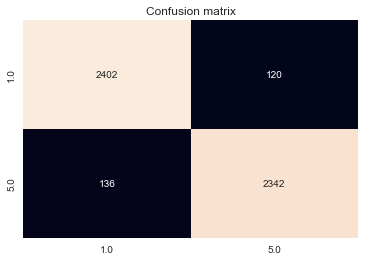

In [20]:
labels = grid_cntv.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

### Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков

#### 1-ый вариант: tf-idf преобразование и сингулярное разложение (оно же – латентый семантический анализ)

##### tf-idf

In [25]:
clf_tf_idf = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression())]
)

params_tf_idf={
    'vect__analyzer': ['word'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l2']
}

scores=['accuracy','f1']

In [26]:
grid_tf_idf = RandomizedSearchCV(
    clf_tf_idf,
    param_distributions=params_tf_idf,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=1
)

In [27]:
grid_tf_idf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\a.pavlovskyi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('tfidf', TfidfTransformer()),
                                             ('clf', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'clf__penalty': ['l2'],
                                        'tfidf__use_idf': (True, False),
                                        'vect__analyzer': ['word'],
                                        'vect__max_df': (0.5, 0.75, 1.0),
                                        'vect__ngram_range': [(1, 1), (2, 2),
                                                              (3, 3)]},
                   refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [28]:
# print(grid_tf_idf.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf.best_score_)

Best score: 0.946


In [29]:
predictions=grid_tf_idf.best_estimator_.predict(X_test)

In [30]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.94      0.97      0.95      2522
         5.0       0.96      0.94      0.95      2478

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



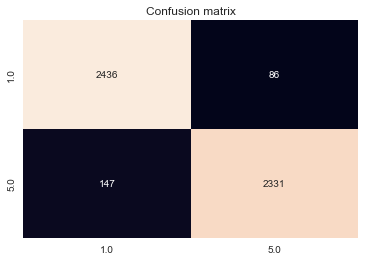

In [31]:
labels = grid_tf_idf.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

##### Cингулярное разложение

In [34]:
clf_tf_idf_TruncatedSVD = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('tsvd', TruncatedSVD()),
     ('clf', LogisticRegression())]
)

params_tf_idf_TruncatedSVD={
    'vect__analyzer': ['word'],
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tsvd__n_components': [5, 10, 25, 50, 100],
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l2']
}

scores=['accuracy','f1']

In [38]:
grid_tf_idf_TruncatedSVD = RandomizedSearchCV(
    clf_tf_idf_TruncatedSVD,
    param_distributions=params_tf_idf_TruncatedSVD,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=1
)

In [39]:
grid_tf_idf_TruncatedSVD.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('tfidf', TfidfTransformer()),
                                             ('tsvd', TruncatedSVD()),
                                             ('clf', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'clf__penalty': ['l2'],
                                        'tsvd__n_components': [5, 10, 25, 50,
                                                               100],
                                        'vect__analyzer': ['word'],
                                        'vect__ngram_range': [(1, 1), (2, 2),
                                                              (3, 3)]},
                   refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [40]:
# print(grid_tf_idf_TruncatedSVD.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf_TruncatedSVD.best_score_)

Best score: 0.923


In [41]:
predictions=grid_tf_idf_TruncatedSVD.best_estimator_.predict(X_test)

In [42]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.92      0.93      0.92      2522
         5.0       0.93      0.91      0.92      2478

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



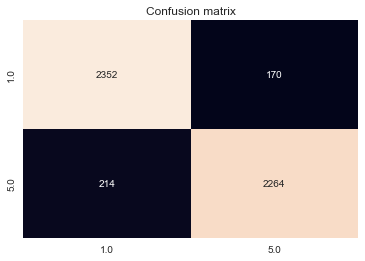

In [43]:
labels = grid_tf_idf.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

### 2-ой вариант: тематические модели LDA. Используйте accuracy и F-measure для оценки качества классификации

In [44]:
clf_tf_idf_LDA = Pipeline(
    [('vect', CountVectorizer()),
     ('lda', LatentDirichletAllocation()),
     ('clf', LogisticRegression())]
)

params_tf_idf_LDA={
    'vect__analyzer': ['word'],
    'vect__max_df': [0.75],
    'vect__ngram_range': [(1, 1)],
    'lda__n_components' : [25, 50, 100],
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l2']
}

scores=['accuracy', 'f1']

In [45]:
grid_tf_idf_LDA = RandomizedSearchCV(
    clf_tf_idf_LDA,
    param_distributions=params_tf_idf_LDA,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=1
)

In [46]:
grid_tf_idf_LDA.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('lda',
                                              LatentDirichletAllocation()),
                                             ('clf', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'clf__penalty': ['l2'],
                                        'lda__n_components': [25, 50, 100],
                                        'vect__analyzer': ['word'],
                                        'vect__max_df': [0.75],
                                        'vect__ngram_range': [(1, 1)]},
                   refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [47]:
# print(grid_tf_idf_LDA.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf_LDA.best_score_)

Best score: 0.906


In [48]:
predictions=grid_tf_idf_LDA.best_estimator_.predict(X_test)

In [49]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.90      0.93      0.91      2522
         5.0       0.93      0.89      0.91      2478

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



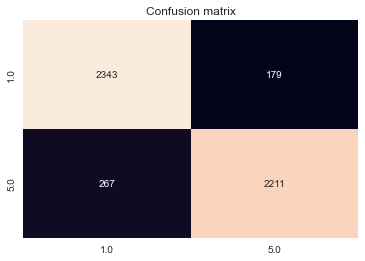

In [50]:
labels = grid_tf_idf_LDA.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

In [51]:
models=['grid_cntv', 'grid_tf_idf', 'grid_tf_idf_TruncatedSVD', 'grid_tf_idf_LDA']

for model in models:
    print(model[5:])
    predictions=eval(model).best_estimator_.predict(X_test)
    print("f1_score: {0:6.3f}\nAccuracy: {0:6.3f}\n\n".format(
        f1_score(y_test, predictions, average='macro'),
        accuracy_score(y_test, predictions)))

cntv
f1_score:  0.949
Accuracy:  0.949


tf_idf
f1_score:  0.953
Accuracy:  0.953


tf_idf_TruncatedSVD
f1_score:  0.923
Accuracy:  0.923


tf_idf_LDA
f1_score:  0.911
Accuracy:  0.911




tf_idf наиболее удачный вариант

In [16]:
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestClassifier
#
# # !!! На каждом этапе Pipeline нужно указать свои параметры
# # 1-ый вариант: tf-idf + LSI
# # 2-ой вариант: LDA
#
# # clf = Pipeline([
# #     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
# #     ('clf', RandomForestClassifier()),
# # ])
#
#
#
# clf = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer()),
#     ('tm', TruncatedSVD()),
#     ('clf', RandomForestClassifier())
# ])